In [1]:
''' 1. Module Import '''
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

C:\Users\user\miniconda3\envs\ml\lib\site-packages\requests\__init__.py:78: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({0}) or chardet ({1}) doesn't match a supported "


In [2]:
''' 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인 '''
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 1.13.0+cpu  Device: cpu


In [3]:
BATCH_SIZE = 32
EPOCHS = 10

In [4]:
''' 3. FashionMNIST 데이터 다운로드 (Train set, Test set 분리하기) '''
train_dataset = datasets.MNIST(root = "../data/MNIST",
                                      train = True,
                                      download = True,
                                      transform = transforms.ToTensor())

test_dataset = datasets.MNIST(root = "../data/MNIST",
                                     train = False,
                                     transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

In [5]:
''' 4. 데이터 확인하기 (1) '''
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


In [6]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

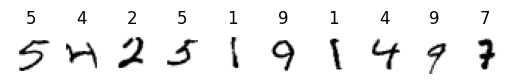

In [7]:
''' 5. 데이터 확인하기 (2) '''
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.title(y_train[i].item())
    plt.imshow(X_train[i].numpy().reshape(28,28), cmap='gray_r')

In [8]:
''' 6. AutoEncorder 모델 설계 '''
class AE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder=  nn.Sequential(
            nn.Linear(28*28,512),
            nn.ReLU(),
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Linear(256,32)  # 잠복공간
        )
        self.decoder=  nn.Sequential(
            nn.Linear(32,256),
            nn.ReLU(),
            nn.Linear(256,512),
            nn.ReLU(),
            nn.Linear(512,28*28)  # 잠복공간
        )
    def forward(self, x):
        print(f"x type is  :{type(x)} ")
        encoder = self.encoder(x)
        decoder = self.decoder(encoder)
        return encoder, decoder      
        

In [9]:
''' 7. Optimizer, model Object, Loss '''
model = AE().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)  # 0.001
criterion = nn.MSELoss() # 평균 제곱오차
print(model)

AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
  )
)


In [10]:
''' 8. Train 함수 '''
from tqdm import tqdm
def train(model, train_loader, optimizer):
    model.train()
    for (images,_) in tqdm(train_loader):  # tqdm 진행상태 표시
        images = images.view(-1,28*28).to(DEVICE)
        target = images.view(-1,28*28).to(DEVICE)
        optimizer.zero_grad()
        encoder, decoder = model(images)
        loss = criterion(decoder,target)
        loss.backward()
        optimizer.step()
        # 진행상태 출력 : 손실률과 정확률 출력
        # output_str = f"loss : {loss.item()}"
        # print(output_str)

In [11]:
''' 9. evaluate 함수 가중치가 없데이트 되지 않도록 한다.  '''
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    real_image = []
    get_image = []
    with torch.no_grad():
        for (images,labels) in test_loader:
            images = images.view(-1,28*28).to(DEVICE)
            target = images.view(-1,28*28).to(DEVICE)
            endcod,decode = model(images)
            test_loss += criterion(decode, images).item()
            real_image.append(images.to('cpu'))
            gen_image.append(decode.to('cpu'))
    test_loss /=  len(test_loader.dataset)
    return test_loss, real_image,gen_image

In [12]:
''' 10. Encorder를 학습하면서 Test set 의 복원율 확인  '''
for epoch in range(1, EPOCHS+1):
    train(model, train_loader, optimizer)
    test_loss, real_image, gen_image =  evaluate(model, test_loader)
    print(f"EPOCH:{epoch} test loss:{test_loss}")
    f, a = plt.subplots(2, 10, figsize = (10, 4))
    for i in range(10): # 정답
        img = np.reshape(real_image[0][i], (28, 28))
        a[0][i].imshow(img, cmap = "gray_r")
        a[0][i].set_xticks(())
        a[0][i].set_yticks(())
    for i in range(10): # 복원
        img = np.reshape(gen_image[0][i], (28, 28))
        a[1][i].imshow(img, cmap = "gray_r")
        a[1][i].set_xticks(())
        a[1][i].set_yticks(())
    plt.show()

100%|██████████████████████████████████████████████████████████████| 1875/1875 [01:00<00:00, 31.21it/s]


TypeError: linear(): argument 'input' (position 1) must be Tensor, not AE